In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
train_data = pd.read_csv("/opt/ml/input/data/train_data.csv")
test_data = pd.read_csv("/opt/ml/input/data/test_data.csv")
print("train_data")
display(train_data.head())
print("\ntest_data")
display(test_data.head())

train_data


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225



test_data


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623


In [3]:
# train_data의 user와 test_data의 user는 서로 다르다
print("train_data unique userID", train_data["userID"].unique()[:20])
print("test_data unique userID", test_data["userID"].unique()[:20])
print(set(train_data["userID"]) == set(test_data["userID"]))
print(set(train_data["userID"]).difference(set(test_data["userID"])) == set(train_data["userID"]))

train_data unique userID [ 0  1  2  5  6  7  8  9 10 11 12 14 15 16 18 19 20 21 22 23]
test_data unique userID [  3   4  13  17  26  29  45  53  58  64  76  79  94 120 159 172 193 200
 203 204]
False
True


In [4]:
# 유저가 가장 마지막으로 푼 문제의 정답 여부를 맞추는 것이 대회 목표
test_data[test_data["userID"] == 3].sort_values("Timestamp")

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623
...,...,...,...,...,...,...
1031,3,A050133004,A050000133,1,2020-10-26 13:12:11,5289
1032,3,A050133005,A050000133,1,2020-10-26 13:12:36,5288
1033,3,A050133006,A050000133,1,2020-10-26 13:12:52,5288
1034,3,A050133007,A050000133,0,2020-10-26 13:13:11,5289


In [5]:
df = pd.concat([train_data, test_data])

9
1860


array([[<AxesSubplot:title={'center':'answered questions per users'}>]],
      dtype=object)

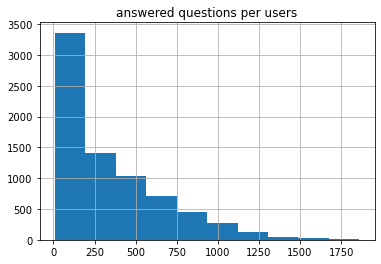

In [6]:
print(min(df.groupby('userID').count()["assessmentItemID"].values))
print(max(df.groupby('userID').count()["assessmentItemID"].values))
pd.DataFrame(df.groupby('userID').count()["assessmentItemID"].values, columns=["answered questions per users"]).hist()

In [7]:
df = df[df["answerCode"] != -1].reset_index(drop=True)
print(df.shape)
df

(2525956, 6)


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2525951,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132
2525952,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832
2525953,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832
2525954,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244


In [8]:
df["test"] = df["assessmentItemID"].map(lambda x: int(x[1:7]))
df["item"] = df["assessmentItemID"].map(lambda x: int(x[-3:]))
df["chapter"] = df["testId"].map(lambda x: int(x[2]))
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test,item,chapter
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,60001,1,6
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,60001,2,6
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,60001,3,6
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,60001,4,6
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,60001,5,6


In [9]:
# testID는 9개의 대단원으로 나눌 수 있다
sorted((df["chapter"]).unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [10]:
# testID, itemID, chapter, KnowledgeTag를 추출한 test 정보
test_info = df[["test", "item", "chapter", "KnowledgeTag"]].drop_duplicates().sort_values(["test", "item", "chapter", "KnowledgeTag"])
test_info

,test,item,chapter,KnowledgeTag
4544,10001,1,1,5844
4545,10001,2,1,5844
4546,10001,3,1,5844
4547,10001,4,1,5844
4548,10001,5,1,5844
...,...,...,...,...
1674,90074,2,9,4243
1675,90074,3,9,4243
1673,90074,4,9,10196
1676,90074,5,9,2648


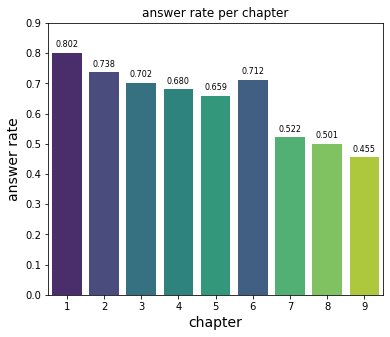

In [11]:
a = df.groupby("chapter").mean()["answerCode"]

# Defining the plot size
plt.figure(figsize=(6, 5))

# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
pal = sns.color_palette("viridis", len(a))
rank = a.argsort().argsort()
plots = sns.barplot(x=a.index, y=a, palette=np.array(pal[::-1])[rank])

# Iterrating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.3f'),
				(bar.get_x() + bar.get_width() / 2,
					bar.get_height()), ha='center', va='center',
				size=8, xytext=(0, 8),
				textcoords='offset points')

# Setting the label for x-axis
plt.xlabel("chapter", size=14)
plt.ylim((0, 0.9))

# Setting the label for y-axis
plt.ylabel("answer rate", size=14)

# Setting the title for the graph
plt.title("answer rate per chapter")

# Finally showing the plot
plt.show()


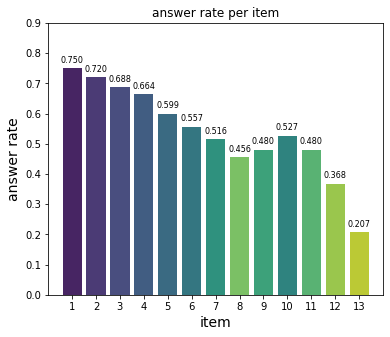

In [12]:
a = df.groupby("item").mean()["answerCode"]

# Defining the plot size
plt.figure(figsize=(6, 5))

# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
pal = sns.color_palette("viridis", len(a))
rank = a.argsort().argsort()
plots = sns.barplot(x=a.index, y=a, palette=np.array(pal[::-1])[rank])

# Iterrating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.3f'),
				(bar.get_x() + bar.get_width() / 2,
					bar.get_height()), ha='center', va='center',
				size=8, xytext=(0, 8),
				textcoords='offset points')

# Setting the label for x-axis
plt.xlabel("item", size=14)
plt.xlim((-1, 13))
plt.ylim((0, 0.9))

# Setting the label for y-axis
plt.ylabel("answer rate", size=14)

# Setting the title for the graph
plt.title("answer rate per item")

# Finally showing the plot
plt.show()


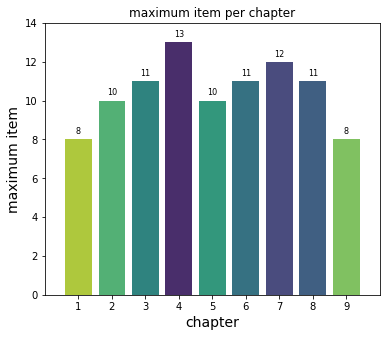

In [13]:
a = test_info.groupby(["chapter", "item"]).count()["test"].reset_index().sort_values(["chapter", "item"])
a.columns = ["chapter", "item", "n_test"]
b = a.groupby("chapter").max()["item"]

# Defining the plot size
plt.figure(figsize=(6, 5))

# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
pal = sns.color_palette("viridis", len(b))
rank = b.argsort().argsort()
plots = sns.barplot(x=b.index, y=b, palette=np.array(pal[::-1])[rank])

# Iterrating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(int(bar.get_height()),
				(bar.get_x() + bar.get_width() / 2,
					bar.get_height()), ha='center', va='center',
				size=8, xytext=(0, 8),
				textcoords='offset points')

# Setting the label for x-axis
plt.xlabel("chapter", size=14)
plt.xlim((-1, 9))
plt.ylim((0, 14))

# Setting the label for y-axis
plt.ylabel("maximum item", size=14)

# Setting the title for the graph
plt.title("maximum item per chapter")

# Finally showing the plot
plt.show()

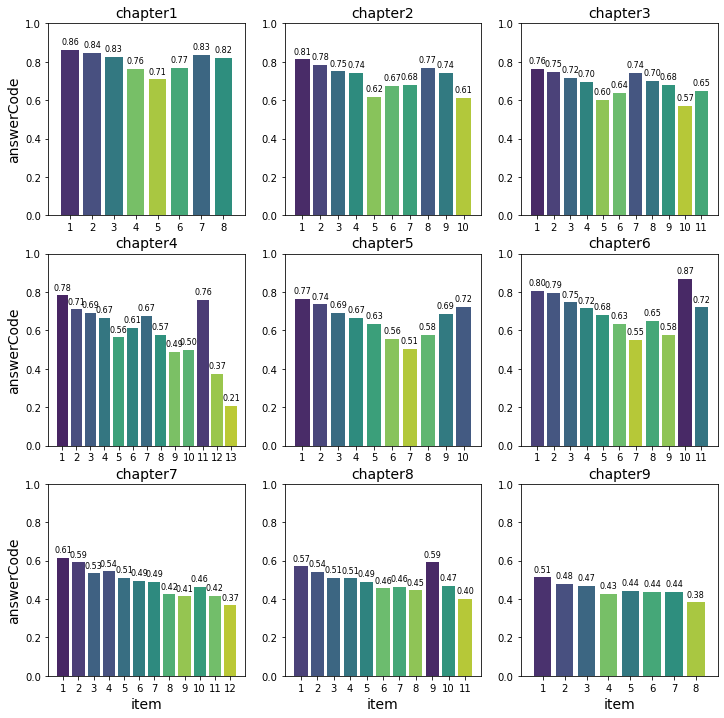

In [14]:
a = df.groupby(["chapter", "item"]).mean()["answerCode"].reset_index()
fig, axes = plt.subplots(3, 3, figsize=(12,12))
axes = axes.flatten()
for i in range(9):
    b = a.loc[a["chapter"]==i+1, ["item", "answerCode"]].set_index("item").squeeze()

    # Defining the values for x-axis, y-axis
    # and from which dataframe the values are to be picked
    pal = sns.color_palette("viridis", len(b))
    rank = b.argsort().argsort()
    plots = sns.barplot(x=b.index, y=b, palette=np.array(pal[::-1])[rank], ax=axes[i])

    # Iterrating over the bars one-by-one
    for bar in plots.patches:
        plots.annotate(format(bar.get_height(), '.2f'),
                    (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                    size=8, xytext=(0, 8),
                    textcoords='offset points')

    # Setting the label for x-axis
    if (i > 5): axes[i].set_xlabel("item", size=14)
    else: axes[i].set_xlabel("", size=14)
    if (i%3 == 0): axes[i].set_ylabel("answerCode", size=14)
    else: axes[i].set_ylabel("", size=14)
    axes[i].set_title("chapter" + str(i+1), size=14)
    axes[i].set_xlim((-1, len(b)))
    axes[i].set_ylim((0, 1))

plt.show()

In [15]:
# KnowledgeTag 7863번을 제외하고는 하나의 KnowledgeTag가 하나의 대단원에만 속한다
chapter_per_KnowledgeTag = test_info.groupby(["chapter", "KnowledgeTag"]).count()["item"].reset_index()
Counter(chapter_per_KnowledgeTag["KnowledgeTag"]).most_common()[:5]
test_info[test_info["KnowledgeTag"] == 7863].sort_values(["test", "item", "chapter"])
# test_info[["KnowledgeTag", "chapter"]].drop_duplicates().groupby("KnowledgeTag").count().reset_index().sort_values(["chapter"], ascending = False)

,test,item,chapter,KnowledgeTag
7835,70139,7,7,7863
9681,70149,3,7,7863
9682,70149,4,7,7863
9685,70149,8,7,7863
5893,70150,3,7,7863
5894,70150,4,7,7863
9693,70151,7,7,7863
5901,70152,3,7,7863
9699,70153,5,7,7863
5911,70154,5,7,7863


In [16]:
a = chapter_per_KnowledgeTag.groupby("chapter").count()["KnowledgeTag"].reset_index()
b = test_info.groupby("chapter").count()["item"].reset_index()
a.merge(b, on = "chapter")

,chapter,KnowledgeTag,item
0,1,64,975
1,2,70,1022
2,3,85,1060
3,4,81,1031
4,5,98,1266
5,6,93,1213
6,7,176,1322
7,8,150,1050
8,9,96,515
